In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import resample, resample_poly
import struct
import imageio
import collections
import pickle
import re
import requests
import pandas as pd
from pathlib2 import Path
import pretty_errors
from filter_BU import filt_B
import my_pyrotd
from awp_processing import awp
from post_processing.la_habra import *

import seaborn as sns
import matplotlib.pyplot as plt

np.errstate(divide='ignore')
#%config InlineBackend.figure_format = 'retina'
# %matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## functions

In [15]:
from obspy.signal.tf_misfit import plot_tfr, em, pm, tem, tpm, fem, fpm, tfem, tfpm

def resize(vel, vel_rec, dt=None):
    length = int(len(vel['t']) * vel['dt'] // dt)
    length_rec = int(len(vel_rec['t']) * vel_rec['dt'] // dt)
    #print(f'Length of time steps = {length}')
    if length > len(vel['t']):
        print(f"Upsample may introduce alias. Use larger dt_sample instead.\n")
        return
    for comp in 'XYZ':
        if length > length_rec:     
            vel[comp] = vel[comp][vel['t'] <= vel_rec['t'][-1]]
            vel[comp] = resample(vel[comp], length_rec)
            vel_rec[comp] = resample(vel_rec[comp], length_rec)
        else:
            vel_rec[comp] = vel_rec[comp][vel_rec['t'] <= vel['t'][-1]]
            vel_rec[comp] = resample(vel_rec[comp], length)
            vel[comp] = resample(vel[comp], length)
            
   
def plot_obspy_tf_misfit(misfit, comps='XYZ', left=0.1, bottom=0.1,
                    h_1=0.2, h_2=0.125, h_3=0.2, w_1=0.2, w_2=0.6, w_cb=0.01,
                    d_cb=0.0, show=True, plot_args=['k', 'r', 'b'], ylim=0.,
                    clim=0., cmap='RdBu_r', fmin=0.15, fmax=5, dpi=300):
    from matplotlib.ticker import NullFormatter
    figs = []
    t = misfit['t']
    f = misfit['f']
    ntr = len(comps)
    for itr, comp in enumerate(comps):
        fig = plt.figure(dpi=dpi)
        data = misfit[comp]
        
        # plot signals
        ax_sig = fig.add_axes([left + w_1, bottom + h_2 + h_3, w_2, h_1])
        ax_sig.plot(t, data['rec'], plot_args[0], label=f'data, max={100 * np.max(data["rec"]):.3f} cm/s')
        ax_sig.plot(t, data['syn'], plot_args[1], label=f'syn, max={100 * np.max(data["syn"]):.3f} cm/s')
        ax_sig.legend(loc=1, ncol=2)

        # plot TEM
        if 'tem' in data:
            ax_tem = fig.add_axes([left + w_1, bottom + h_1 + h_2 + h_3, w_2, h_2])
            ax_tem.plot(t, data['tem'], plot_args[2])

        # plot TFEM
        if 'tfem' in data:
            ax_tfem = fig.add_axes([left + w_1, bottom + h_1 + 2 * h_2 + h_3, w_2,
                                    h_3])

            img_tfem = ax_tfem.pcolormesh(t, f, data['tfem'], cmap=cmap)
            img_tfem.set_rasterized(True)
            ax_tfem.set_yscale("log")
            ax_tfem.set_ylim(fmin, fmax)

        # plot FEM
        if 'fem' in data:
            ax_fem = fig.add_axes([left, bottom + h_1 + 2 * h_2 + h_3, w_1, h_3])
            ax_fem.semilogy(data['fem'], f, plot_args[2])
            ax_fem.set_ylim(fmin, fmax)

        # plot TPM
        if 'tpm' in data:
            ax_tpm = fig.add_axes([left + w_1, bottom, w_2, h_2])
            ax_tpm.plot(t, data['tpm'], plot_args[2])

        # plot TFPM
        if 'tfpm' in data:
            ax_tfpm = fig.add_axes([left + w_1, bottom + h_2, w_2, h_3])

            img_tfpm = ax_tfpm.pcolormesh(t, f, data['tfpm'], cmap=cmap)
            img_tfpm.set_rasterized(True)
            ax_tfpm.set_yscale("log")
            ax_tfpm.set_ylim(f[0], f[-1])

        # add colorbars
        ax_cb_tfpm = fig.add_axes([left + w_1 + w_2 + d_cb + w_cb, bottom,
                                   w_cb, h_2 + h_3])
        fig.colorbar(img_tfpm, cax=ax_cb_tfpm)

        # plot FPM
        if 'fpm' in data:
            ax_fpm = fig.add_axes([left, bottom + h_2, w_1, h_3])
            ax_fpm.semilogy(data['fpm'], f, plot_args[2])
            ax_fpm.set_ylim(fmin, fmax)

        # set limits
        ylim_sig = np.max([np.abs(data['rec']).max(), np.abs(data['syn']).max()]) * 2
        ax_sig.set_ylim(-ylim_sig, ylim_sig)

        if ylim == 0.:
            ylim = np.max([np.abs(data[key]).max() for key in ['tem', 'tpm', 'fem', 'fpm'] \
                           if key in data]) * 1.1
    
        ax_tem.set_ylim(-ylim, ylim)
        ax_fem.set_xlim(-ylim, ylim)
        ax_tpm.set_ylim(-ylim, ylim)
        ax_fpm.set_xlim(-ylim, ylim)

        ax_sig.set_xlim(t[0], t[-1])
        ax_tem.set_xlim(t[0], t[-1])
        ax_tpm.set_xlim(t[0], t[-1])

        if clim == 0.:
            clim = np.max([np.abs(data['tfem']).max(), np.abs(data['tfpm']).max()])

        img_tfpm.set_clim(-clim, clim)
        img_tfem.set_clim(-clim, clim)

        # add text box for EM + PM
        textstr = f"{comp}-component\nEM = {data['em']: .2f}\nPM = {data['pm']: .2f}"
        props = dict(boxstyle='round', facecolor='white')
        ax_sig.text(-0.3, 0.5, textstr, transform=ax_sig.transAxes,
                    verticalalignment='center', horizontalalignment='left',
                    bbox=props)

        ax_tpm.set_xlabel('time (s)')
        ax_fem.set_ylabel('frequency (Hz)')
        ax_fpm.set_ylabel('frequency (Hz)')

        # add text boxes
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax_tfem.text(0.95, 0.85, 'TFEM', transform=ax_tfem.transAxes,
                     verticalalignment='top', horizontalalignment='right',
                     bbox=props)
        ax_tfpm.text(0.95, 0.85, 'TFPM', transform=ax_tfpm.transAxes,
                     verticalalignment='top', horizontalalignment='right',
                     bbox=props)
        ax_tem.text(0.95, 0.75, 'TEM', transform=ax_tem.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=props)
        ax_tpm.text(0.95, 0.75, 'TPM', transform=ax_tpm.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=props)
        ax_fem.text(0.9, 0.85, 'FEM', transform=ax_fem.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=props)
        ax_fpm.text(0.9, 0.85, 'FPM', transform=ax_fpm.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=props)

        # remove axis labels
        ax_tfpm.xaxis.set_major_formatter(NullFormatter())
        ax_tfem.xaxis.set_major_formatter(NullFormatter())
        ax_tem.xaxis.set_major_formatter(NullFormatter())
        ax_sig.xaxis.set_major_formatter(NullFormatter())
        ax_tfpm.yaxis.set_major_formatter(NullFormatter())
        ax_tfem.yaxis.set_major_formatter(NullFormatter())

        figs.append(fig)

    if show:
        plt.show()
    else:
        if ntr == 1:
            return figs[0]
        else:
            return figs
        
        
def comp_obspy_tf_misfit(model, site_name, dt, comps='XYZ', 
                         fmin=0.15, fmax=5, nf=128, vel=None, vel_rec=None, plot=False):
    if vel is None:
        with open('results/vel_syn.pickle', 'rb') as fid:
            vel_syn = pickle.load(fid)
        vel = vel_syn[model][site_name]
        vel_rec = vel_syn["rec"][site_name]
        
    resize(vel, vel_rec, dt)
    res = {}
    res['dt'] = dt
    res['f'] = np.logspace(np.log10(fmin), np.log10(fmax), nf)
    
    for comp in comps:
        res[comp] = {}
        res[comp]['syn'] = vel[comp]
        res[comp]['rec'] = vel_rec[comp]
        res[comp]['em'] = em(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['pm'] = pm(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['tfem'] = tfem(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['tfpm'] = tfpm(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['tem'] = tem(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['tpm'] = tpm(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['fem'] = fem(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['fpm'] = fpm(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
    res['t'] = np.arange(res[comp]['tem'].shape[-1]) * dt
    if plot:
        plot_obspy_tf_misfit(res, comps=comps)
    return res
        
    
    
def comp_obspy_tf_misfits(models, dt, comps='XYZ', fmin=0.15, fmax=5, nf=128):
    misfit = {}
    with open('results/vel_syn.pickle', 'rb') as fid:
        vel_syn = pickle.load(fid)
        
    for model in models:
        misfit[model] = {}
        vel = vel_syn[model]
        vel_rec = vel_syn['rec']
        for site_name in vel_syn[model].keys():
            print(f'{model}: {site_name}')
            misfit[model][site_name] = comp_obspy_tf_misfit( \
                    model, site_name, dt, comps=comps, fmin=fmin, fmax=fmax, 
                    nf=nf, vel=vel[site_name], vel_rec=vel_rec[site_name])
    return misfit

def comp_obspy_tf_misfit_short(model, site_name, dt, comps='XYZ', 
                         fmin=0.15, fmax=5, nf=128, vel=None, vel_rec=None, plot=False):
    if vel is None:
        with open('results/vel_syn.pickle', 'rb') as fid:
            vel_syn = pickle.load(fid)
        vel = vel_syn[model][site_name]
        vel_rec = vel_syn["rec"][site_name]
        
    resize(vel, vel_rec, dt)
    res = {}
    res['dt'] = dt
    res['f'] = np.logspace(np.log10(fmin), np.log10(fmax), nf)
    
    for comp in comps:
        res[comp] = {}
        res[comp]['syn'] = vel[comp]
        res[comp]['rec'] = vel_rec[comp]
        res[comp]['em'] = em(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['pm'] = pm(vel[comp], vel_rec[comp], dt, fmin, fmax, nf)
        res[comp]['eg'] = 10 * np.exp(-abs(res[comp]['em']))
        res[comp]['pg'] = 10 * (1 - np.abs(res[comp]['pm']))
    res['t'] = np.arange(len(res[comp]['syn'])) * dt
    return res


def comp_obspy_tf_misfits_short(models, dt, comps='XYZ', fmin=0.15, fmax=5, nf=128):
    with open('results/vel_syn.pickle', 'rb') as fid:
        vel_syn = pickle.load(fid)
        
    misfit = {}
    for model in models:
        misfit[model] = {}
        vel = vel_syn[model]
        vel_rec = vel_syn['rec']
        for i, site_name in enumerate(vel_syn[model].keys()):
            if i % 50 == 0:
                print(f'{model}: {site_name}')
            tmp = comp_obspy_tf_misfit_short( \
                    model, site_name, dt, comps=comps, fmin=fmin, fmax=fmax, 
                    nf=nf, vel=vel[site_name], vel_rec=vel_rec[site_name])
            out = []
            for i, comp in enumerate(comps):
                out.append(tmp[comp]['em'])  
                out.append(tmp[comp]['pm'])  
            for i, comp in enumerate(comps):
                out.append(tmp[comp]['eg'])  
                out.append(tmp[comp]['pg'])
            misfit[model][site_name] = np.array(out, dtype='float32').reshape(6, 2)
    return misfit

In [16]:
def distance(lon1, lat1, lon2=-117.932587, lat2=33.918633):
    lat1, lon1, lat2, lon2 = np.radians((lat1, lon1, lat2, lon2))
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    d = 0.5 - np.cos(dlat) / 2 + np.cos(lat1) * np.cos(lat2)  * (1 - np.cos(dlon)) / 2
    return 12742 * np.arcsin(np.sqrt(d))

In [17]:
def read_pickle(fname):
    return  pickle.loads(Path(fname).read_bytes())

def write_pickle(data, fname):
    with open(fname, 'wb') as fid:
        pickle.dump(data, fid, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
def read_topo(fname, mx, my):
    """Return topog (my, mx)"""
    pad = 8
    with open(fname, 'rb') as fout:
        mx, my, pad = np.frombuffer(fout.read(12), dtype='int32')
        topo = np.frombuffer(fout.read((mx + 2 * pad) * (my + 2 * pad) * 4),
                             dtype='float32').reshape(mx + 2 * pad, my + 2 * pad).T
        return topo[pad : -pad, pad : -pad]

In [19]:
# band pass filter
lowf, highf = 0.15, 5
osc_freqs = np.concatenate((np.linspace(0.1, 10, 100),
                        [1/3, 2, 3, 4, 5]))
osc_freqs = sorted(osc_freqs)
fqs = [2, 3, 4, 5]


mx, my = 19440, 14904
dh = 8
tmax, dt, tskip, wstep, nfile = read_param("")
tpad = tmax + 5  # Padding 5 seconds when using bbs preparing
nd = 500  # avoid abc boudnary, which is at most 80 * 3 = 240
dt = dt * tskip
nt = int(tmax / dt)
fs = 1 / dt

# Topography
if "topography" not in locals():
    topography = read_topo('topography.bin', mx, my)
#     topo_grad = np.gradient(topography, dh)
#     topo_grad = np.sqrt(topo_grad[0] ** 2 + topo_grad[1] ** 2)
    
# sites of recordings
# url_rec = 'http://hypocenter.usc.edu/bbp/highf/data/2020-08-10-data-processed/'
# r = requests.get(url_rec)
# rec_sites = re.findall('(?<=">p-).+(?=\\.V2.vel)', r.text)

# orig_sites = np.genfromtxt('stat_name_idx.txt', delimiter=" ", dtype="S8, i4, i4")
# seems Fabio doesn't remove "_" in site name now
if os.path.isfile('results/syn_sites.pickle'):
    with open('results/syn_sites.pickle', 'rb') as fid:
        syn_sites = pickle.load(fid)
else:
    syn_sites = [(name.decode('UTF-8').replace('_', ''), ix, iy) for name, ix, iy in orig_sites \
             if nd < ix < mx - nd and nd < iy < my - nd] 
    with open('results/syn_sites.pickle', 'wb') as fid:
        pickle.dump(syn_sites, fid, protocol=pickle.HIGHEST_PROTOCOL)

# Source index 
if 1:# and 'srcidx' not in locals():
#     grids = np.fromfile('surf.grid', dtype='float64').reshape(my, mx, 3)[:, :, :2]
#     grids_squeeze = np.reshape(grids, (-1, 2))
    nsrcx = nsrcz = 125
    src_lonlat = [-117.932587, 33.918633]
    src_idx = np.genfromtxt('fault_idx.txt', dtype='int').reshape(nsrcz, nsrcx, 3)
    print(src_idx[0][0])
    srcidx = [int(x) for x in (np.mean(src_idx, axis=(0, 1)))]  # (ix, iy, iz)
    
    print(srcidx)
    # from scipy import spatial
    # kdtree = spatial.cKDTree(grids_squeeze)
    # query_idx = np.unravel_index(kdtree.query(src_lonlat)[1], (my, mx))  # (iy, ix)
    # srcidx = query_idx[::-1] + (srcidx[-1],)  #(ix, iy, iz)
    # srcidx = [4037, 2732, 709]
#     print(f'Interpolated source lon/lat: {grids[srcidx[1], srcidx[0]]}\n', 
#           f'Close to records? {np.isclose(grids[srcidx[1], srcidx[0]], src_lonlat, atol=5e-5)}')
#     del grids

site_latlon = np.genfromtxt('la_habra_large_statlist_070120.txt', usecols=[0,1,2,3], dtype="S8, f, f, f")
site_dist = {}
site_vs30 = {}
site_elev = {}
site_idx = {}
for i in range(len(site_latlon)):
    site_name = site_latlon[i][0].decode('UTF-8').replace('_', '')
    site_idx[site_name] = (syn_sites[i][1], syn_sites[i][2])
    site_dist[site_name] = np.sqrt((srcidx[-1] * dh / 1000) ** 2 +  \
                           distance(site_latlon[i][1], site_latlon[i][2]) ** 2)
    site_vs30[site_name] = site_latlon[i][3]
    site_elev[site_name] = topography[syn_sites[i][2], syn_sites[i][1]]

sorted_site_elev = [(k, v) for k, v in sorted(site_elev.items(), key=lambda x: x[1])]
sorted_site_dist = [(k, v) for k, v in sorted(site_dist.items(), key=lambda x: x[1])]


  
# # VS30 is at the approxmately 5th layer; skip = 4
# from scipy.stats import hmean
# vs30 = np.fromfile('mesh', dtype='float32', count=mx * my * 3 * 3).reshape(3, my, mx, 3)[:, :, :, 1]
# vs30 = hmean(vs30, axis=0)

[9783 5215  564]
[9681, 5086, 709]


In [50]:
ds = []
for i in range(len(site_latlon)):
    d = {}
    site_name = site_latlon[i][0].decode('UTF-8').replace('_', '')
    d["site_name"] = site_name 
    d["lon"] = site_latlon[i][1]
    d["lat"] = site_latlon[i][2]
    d["idx_x"] = syn_sites[i][1]
    d["idx_y"] = syn_sites[i][2]
    d["vs30"] = site_latlon[i][3]
    d["elevation"] = topography[syn_sites[i][2], syn_sites[i][1]]
    d["rhyp"] = site_dist[site_name]
    ds.append(d)
df_sites = pd.DataFrame(ds, index=None)
df_sites.set_index('site_name', drop=True, inplace=True)
df_sites.sort_values("rhyp", inplace=True)
#df_sites.reset_index(drop=False, inplace=True)
#df_sites.to_csv("results/df_sites.csv", index=False)

# or row.idx_x < srcidx[0]
df_sites['west'] = df_sites.apply(lambda row: "west" if row.lon < src_lonlat[0] \
                                 else "east", axis=1)
site_info = df_sites.columns.tolist()
%store df_sites
df_sites.head()


Stored 'df_sites' (DataFrame)


,lon,lat,idx_x,idx_y,vs30,elevation,rhyp,west
site_name,,,,,,,,
CE13880,-117.931099,33.908600,9833,4972,324.0,97.820633,5.782308,east
CE13881,-117.955704,33.931499,9412,5037,353.0,86.594948,6.226369,west
CIOLI,-117.923721,33.945389,9575,5420,328.0,159.873169,6.456924,east
CE13873,-117.896301,33.933102,9928,5490,423.0,117.233238,6.780003,east
CIFUL,-117.922508,33.871700,10234,4640,309.0,52.210217,7.763477,east


In [8]:
left, right, bot, top = -118.5, -117.23, 33.6, 34.35

labels = {'arias': r'Arias (cm/s)', 'pga': r'PGA (cm/s@+2@+)', 'pgv': r'PGV (cm/s)',
          'ener': r'ENER (cm/s@+2@+)', 'dur': 'DUR (s)'}
metrics = list(labels.keys())

model_dict = {
    'rec': 'data',
    'dhyp0.50_s1485839278_q100f00_orig_vs200': "src0_vs200",
    'dhyp0.50_s1485839278_q100f00_orig_vs500': "src0_vs500",
    'dhyp1.00_s387100462_q100f00_orig_vs200': "src1_vs200",
    'dhyp1.50_s372823598_q100f00_orig_vs200': "src2_vs200",
    'dhyp0.50_s1485839278_q100f00_s05h005l100_vs200': "src0_s5h5l100vs200",
    'dhyp0.50_s1485839278_q100f00_s05h005l500_vs200': "src0_s5h5l500vs200",
    'dhyp0.50_s1485839278_q100f00_s10h005l500_vs200': "src0_s10h5l500vs200",
    'q100f00_orig_vs500': "vs500",
    'q100f06_orig_vs500': "q100f06_vs500",
    "topo_q100f00_orig_vs500": "tp_vs500",
    'topo_q100f00_s05h005l100_vs500': "tp_s5h5l100_vs500",
    'topo_q100f06_s05h005l100_vs500': "tp_q100f06_s5h5l100_vs500",
    'topo_q50f06_s05h005l100_vs500': "tp_q50f06_s5h5l100_vs500",
    'topo_q50f08_s05h005l100_vs500': "tp_q50f08_s5h5l100_vs500",
}
model_id = {k: i for i, k in enumerate(model_dict)}

%store model_dict
%store model_id

Stored 'model_dict' (dict)
Stored 'model_id' (dict)


## Metric preparation

### Velocity

In [10]:
vel_syn = collections.defaultdict(dict)


models = ['dhyp0.50_s1485839278_q100f00_orig_vs200',
          'dhyp0.50_s1485839278_q100f00_orig_vs500',
          'dhyp1.50_s372823598_q100f00_orig_vs200',
          'dhyp1.00_s387100462_q100f00_orig_vs200',
          'dhyp0.50_s1485839278_q100f00_s05h005l100_vs200',
          'dhyp0.50_s1485839278_q100f00_s05h005l500_vs200',
          'dhyp0.50_s1485839278_q100f00_s10h005l500_vs200',
          'rec']

with open('results/vel_syn.pickle', 'rb') as fid:
    vel_syn = pickle.load(fid)


# models = ['dhyp0.50_s1485839278_q100f00_orig_vs200']
# for model in models:
#     if model in vel_syn.keys():
#         continue
#     try:
#         with open(Path(model, 'vel_sites.pickle'), 'rb') as fid:      
#             vel_syn[model] = pickle.load(fid) 
#             for k in vel_syn[model].keys():  # Each site
#                 vel_syn[model][k] = rotate(vel_syn[model][k], -39.9)
#                 vel_syn[model][k] = prepare_bbpvel(vel_syn[model][k], tmax)

#     except:
#         print("No model found: ", model)
#         with open(f'results/vel_{model}.pickle', 'rb') as fid:
#             vel_syn[model] = pickle.load(fid)
            
# with open(f'results/vel_rec.pickle', 'rb') as fid:
#     vel_syn['rec'] = pickle.load(fid)
# # for k in vel_syn['rec'].keys():  # Each site
# #     vel_syn['rec'][k] = prepare_bbpvel(vel_syn['rec'][k], tmax, shift=vel_syn['rec'][k]['shift'], 
# #                                        dt=vel_syn['dhyp0.50_s1485839278_q100f00_orig_vs200'][k]['dt'])

with open(Path("../la_habra_large_gpu_abc50/topo_q50f08_s05h005l100_vs500", 'vel_sites.pickle'), 'rb') as fid:      
    tmp = pickle.load(fid) 
    for k in tmp.keys():  # Each site
        tmp[k] = rotate(tmp[k], -39.9)
        tmp[k] = prepare_bbpvel(tmp[k], tmax)

vel_syn['topo_q50f08_s05h005l100_vs500'] = tmp

with open('results/vel_syn.pickle', 'wb') as fid:
    pickle.dump(vel_syn, fid, protocol=pickle.HIGHEST_PROTOCOL) 

In [ ]:
# # Read bbp-format recordings

# def read_bbp(texts):
#     res = {}
#     data = np.genfromtxt(texts)
#     res['t'] = data[:, 0]
#     res['dt'] = data[1, 0] - data[0, 0]
#     for i, comp in enumerate('YXZ', 1):
#         res[comp] = dat[:, i] / 100  # cm/s2 --> m/s2
#     return res

# vel_rec = collections.defaultdict(dict)
# for i, isite in enumerate(orig_sites):
#     site_name = isite[0].decode('UTF-8')
#     r = requests.get(f'{url_rec}/p-{site_name}.V2.vel.bbp')
#     if r.status_code != 200:
#         print(f"the site {site_name} not found on the server")
#         continue
#     vel_rec[site_name.replace('_', '')] = read_bbp(r.text.split('\n'))
# vel_syn['rec'] = vel_rec

# # End reading


# with open('results/vel_syn.pickle', 'wb') as fid:
#     pickle.dump(vel_syn, fid, protocol=pickle.HIGHEST_PROTOCOL) 

In [10]:
# with open(Path("../la_habra_large_gpu_abc50/topo_q100f06_s05h005l100_vs500", 'vel_sites.pickle'), 'rb') as fid:      
#     tmp = pickle.load(fid) 
#     for k in tmp.keys():  # Each site
#         tmp[k] = rotate(tmp[k], -39.9)
#         tmp[k] = prepare_bbpvel(tmp[k], tmax)

# vel_syn['topo_q100f06_s05h005l100_vs500'] = tmp
# with open('results/vel_syn.pickle', 'wb') as fid:
#     pickle.dump(vel_syn, fid, protocol=pickle.HIGHEST_PROTOCOL) 


### SA

In [540]:
with open('results/psa_syn.pickle', 'rb') as fid:
    psa_syn = pickle.load(fid)
    
# models = ['dhyp0.50_s1485839278_q100f00_orig_vs200',
#           'dhyp0.50_s1485839278_q100f00_orig_vs500',
#           'dhyp1.50_s372823598_q100f00_orig_vs200',
#           'dhyp1.00_s387100462_q100f00_orig_vs200',
#           'dhyp0.50_s1485839278_q100f00_s05h005l100_vs200',
#           'dhyp0.50_s1485839278_q100f00_s05h005l500_vs200',
#           'dhyp0.50_s1485839278_q100f00_s10h005l500_vs200',
#           'rec',
#          ]
models = ['topo_q100f06_s05h005l100_vs500']
psa_syn = pick_psa(mx, my, models, force_update=True,
                   osc_freqs=osc_freqs, syn_sites=syn_sites)


Models queried!
['topo_q100f06_s05h005l100_vs500']

Gathering psa_syn for CE12919, 0/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13066, 1/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13067, 2/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13068, 3/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13069, 4/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13079, 5/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13080, 6/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13096, 7/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13098, 8/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13099, 9/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13100, 10/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13123, 11/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13160, 12/259
: topo_q100f06_s05h005l100_vs500
Gathering psa_syn for CE13162, 13/2

### tf_misfit

In [ ]:
# Run this one
# EM/PM/EG/PG only tf_misfit

dt = 0.04
try:
    tf_misfit = pickle.loads(Path('results/tf_misfit.pickle').read_bytes())
except:
    tf_misfit = {}
    
models = ['dhyp0.50_s1485839278_q100f00_orig_vs200',
          'dhyp0.50_s1485839278_q100f00_orig_vs500',
          'dhyp1.50_s372823598_q100f00_orig_vs200',
          'dhyp1.00_s387100462_q100f00_orig_vs200',
          'dhyp0.50_s1485839278_q100f00_s05h005l100_vs200',
          'dhyp0.50_s1485839278_q100f00_s05h005l500_vs200',
          'dhyp0.50_s1485839278_q100f00_s10h005l500_vs200']
models = [
    #'topo_q50f08_s05h005l100_vs500',
    'topo_q100f00_orig_vs500',
    'topo_q100f06_s05h005l100_vs500',
]
tmp = {}
for f in [(0.15, 2.5), (0.15, 5), (2.5, 5), (0.15, 1), (0.15, 4)]:
    tf_misfit[f].pop('topo_q100f00_orig_vs500')
    tf_misfit[f].pop('topo_q100f06_s05h005l100_vs500')
    if f not in tf_misfit:
        tf_misfit[f] = {}
    models = [model for model in models if model not in tf_misfit[f]]
    tmp = comp_obspy_tf_misfits_short(models, dt, fmin=f[0], fmax=f[1])
    for model in models:
        print(model)
        tf_misfit[f][model] = tmp[model]
print(tf_misfit[(0.15, 2.5)].keys())


# # force rec tf_misfits
# rec_tf_misfit = np.zeros((6, 2))
# rec_tf_misfit[3:,:] = 10.
# for f in tf_misfit.keys():
#     tf_misfit[f]['rec'] = {}
#     for site_name in tf_misfit[f][models[0]].keys():
#         tf_misfit[f]['rec'][site_name] = rec_tf_misfit.copy()
        
with open('results/tf_misfit.pickle', 'wb') as fid:
    pickle.dump(tf_misfit, fid, protocol=pickle.HIGHEST_PROTOCOL)

### Metrics & GOF

In [22]:
# models = ['dhyp0.50_s1485839278_q100f00_orig_vs200',
#           'dhyp0.50_s1485839278_q100f00_orig_vs500',
#           'dhyp1.50_s372823598_q100f00_orig_vs200',
#           'dhyp1.00_s387100462_q100f00_orig_vs200',
#           'dhyp0.50_s1485839278_q100f00_s05h005l100_vs200',
#           'dhyp0.50_s1485839278_q100f00_s05h005l500_vs200',
#           'dhyp0.50_s1485839278_q100f00_s10h005l500_vs200',
#          ]
# models = [
#     'topo_q50f08_s05h005l100_vs500',
#     'topo_q100f00_orig_vs500',
#     'topo_q100f06_s05h005l100_vs500',
# ]

# comp_metrics(models, vel_syn, lowcut=0.15, highcut=[0, 1, 2.5, 4, 5],
#              tmax=tmax, force_update=1, save=True) 
# comp_metrics(models, vel_syn, lowcut=2.5, highcut=[5], tmax=tmax,
#              force_update=1, save=True)  

met = pickle.loads(Path('results/metrics.pickle').read_bytes())
# models = list(met[(0.15, 1)].keys())

# gof = comp_GOF([0, 1, 2.5, 4, 5, (2.5, 5)] , models, vs=site_vs30, 
#     syn_sites=syn_sites, topography=topography, sx=srcidx[0], sy=srcidx[1],
#         sz=srcidx[2], dh=0.008)


gof = pickle.loads(Path('results/gof.pickle').read_bytes())

In [23]:
# Merge previous results if not present
if 0:
    tmp = read_pickle("../la_habra_large_gpu_abc50/results/vel_syn.pickle")
    vel = pickle.loads(Path('results/vel_syn.pickle').read_bytes())
    if model not in vel:
        vel[model] = tmp[model]
    write_pickle(vel, 'results/vel_syn.pickle')

    tmp = read_pickle("../la_habra_large_gpu_abc50/results/psa_syn.pickle")
    psa = pickle.loads(Path('results/psa_syn.pickle').read_bytes())
    for model in tmp.keys():
        if model not in psa:
            psa[model] = tmp[model]
    write_pickle(psa, 'results/psa_syn.pickle')

    tmp = read_pickle("../la_habra_large_gpu_abc50/results/psax_syn.pickle")
    psa = pickle.loads(Path('results/psax_syn.pickle').read_bytes())
    for model in tmp.keys():
        if model not in psa:
            psa[model] = tmp[model]
    write_pickle(psa, 'results/psax_syn.pickle')

    tmp = read_pickle("../la_habra_large_gpu_abc50/results/psay_syn.pickle")
    psa = pickle.loads(Path('results/psay_syn.pickle').read_bytes())
    for model in tmp.keys():
        if model not in psa:
            psa[model] = tmp[model]
    write_pickle(psa, 'results/psay_syn.pickle')


    tmp = read_pickle("../la_habra_large_gpu_abc50/results/gof.pickle")
    gof = pickle.loads(Path('results/gof.pickle').read_bytes())
    for f in tmp.keys():
        for model in tmp[f].keys():
            if f in gof and model not in gof[f]:
                gof[f][model] = tmp[f][model]
    write_pickle(gof, 'results/gof.pickle')


    tmp = read_pickle("../la_habra_large_gpu_abc50/results/metrics.pickle")
    met = pickle.loads(Path('results/metrics.pickle').read_bytes())
    for f in tmp.keys():
        for model in tmp[f].keys():
            if f in met and model not in met[f]:
                met[f][model] = tmp[f][model]
    write_pickle(met, 'results/metrics.pickle')

    tmp = read_pickle("../la_habra_large_gpu_abc50/results/tf_misfit.pickle")
    tf_misfit = pickle.loads(Path('results/tf_misfit.pickle').read_bytes())
    for f in tmp.keys():
        for model in tmp[f].keys():
            if f in tf_misfit and model not in tf_misfit[f]:
                tf_misfit[f][model] = tmp[f][model]
    write_pickle(tf_misfit, 'results/tf_misfit.pickle')

    del tmp

In [12]:
## Single tf_misfit for 0.15 - 5 Hz, with all components, fem, fpm ...


# fmin, fmax = 0.15, 5
# models = ['dhyp0.50_s1485839278_q100f00_orig_vs200']
# obspy_tf_misfit = pickle.loads(Path('results/obspy_tf_misfit.pickle').read_bytes())

# # if os.path.isfile('results/obspy_tf_misfit.pickle'):
# #     obspy_tf_misfit = pickle.load(open('results/obspy_tf_misfit.pickle', 'rb'))
# # else:
# dt = 0.04
# for model in models:
#     if model not in obspy_tf_misfit:
#         obspy_tf_misfit[model] = comp_obspy_tf_misfits([model], dt).pop(model)

# #     with open('results/obspy_tf_misfit.pickle', 'wb') as fid:
# #         pickle.dump(obspy_tf_misfit, fid, protocol=pickle.HIGHEST_PROTOCOL)


### Temp

In [25]:
# Construct the DataFrame from met and gof

idx = pd.IndexSlice

df = pd.DataFrame.from_dict(
    {
        (f, model, site_name) : met[f][model][site_name]
             for f in sorted(met.keys())
             for model in met[f]
             for site_name in met[f][model].keys()
    },
    orient='index')
df = df.sort_index().sort_index(axis=1).unstack(0).unstack(0)

df_gof = pd.DataFrame.from_dict(
    {
        (f, model, site_name) : gof[f][model][site_name]
             for f in sorted(gof.keys())
             for model in gof[f]
             for site_name in gof[f][model].keys()
    },
    orient='index')
df_gof = df_gof.sort_index().sort_index(axis=1).unstack(0).unstack(0)
df_gof.drop(['rhypo', 'vs', 'elev'], axis=1, level=0, inplace=True)


# psa
psa = pickle.loads(Path('results/psa_syn.pickle').read_bytes())
freqs = pd.Series([1,2,3,3.5], name='freq')  # frequencies of PSA to query

index = pd.MultiIndex.from_product([
    ['psa'],
    freqs,
    df.columns.unique(2),
], names=df.columns.names)
df_psa = pd.DataFrame(index=df.index, columns=index)

for model in df_psa.columns.unique(2):  # model label
    osc_freqs = psa[model][df.index[0]].osc_freq
    for freq in df_psa.columns.unique(1):  # freq label
        idx_f = np.searchsorted(osc_freqs, freq)
        for site_name in df_psa.index:
            df_psa.loc[site_name, idx['psa', freq, model]] = \
                       psa[model][site_name].spec_accel[idx_f]
    
    
df = df.join(df_gof).join(df_psa)

# # Append site information from df_sites
# tmp = df_sites.copy()
# df[tmp.columns] = tmp


# # Sort by rhyp
# df.sort_values('rhyp', axis=0, inplace=True)
# df.sort_index(key = lambda x : df_sites.loc[x]['rhyp'], inplace=True)


# Rename column levels
df.rename_axis(["metric", "freq", "model"], axis=1, inplace=True)
df.head(2)


# Write to disk
%store df
write_pickle(df, "results/df.pickle")

Stored 'df' (DataFrame)


In [56]:
def plot_var_metric(models, fs, metric, ref_model='rec'):
    models = [model for model in models if model != ref_model]
    data = df.loc[:, idx[metric, fs, models + [ref_model] + site_info]] \
        .droplevel([0], axis=1)
    for f in fs:
        for model in models:
            data[f, model] = data[f, model] / data[f, ref_model]
        out = data.unstack().reset_index([0,1])  # Move freq and model to columns
        out = out.join(df_sites)
        out.rename(columns={out.columns[2]: metric}, inplace=True)
    return out

In [57]:
metric = 'pgv'
fs = [(0.15, 1), (0.15, 2.5), (2.5, 5)]  # avoid Pandas split the tuple
models = [
    'rec',
    'topo_q50f08_s05h005l100_vs500',
]
out = plot_var_metric(models, fs, metric, ref_model='rec')
out.head()

,freq,model,pgv,lon,lat,idx_x,idx_y,vs30,elevation,rhyp,west
CE12919,"(0.15, 1)",rec,0.271075,-116.972603,33.929901,18172,12266,333.0,795.500122,88.764685,east
CE12919,"(0.15, 1)",topo_q50f08_s05h005l100_vs500,0.493570,-116.972603,33.929901,18172,12266,333.0,795.500122,88.764685,east
CE12919,"(0.15, 2.5)",rec,0.402878,-116.972603,33.929901,18172,12266,333.0,795.500122,88.764685,east
CE12919,"(0.15, 2.5)",topo_q50f08_s05h005l100_vs500,0.640938,-116.972603,33.929901,18172,12266,333.0,795.500122,88.764685,east
CE12919,"(2.5, 5)",rec,0.210373,-116.972603,33.929901,18172,12266,333.0,795.500122,88.764685,east


In [75]:
east_sites = out[(out['west'] == 'west') & (out['rhyp'] > 40) \
              & (out['freq'] == (2.5, 5))]
east_sites = east_sites[~east_sites.index.duplicated(keep='last')]
east_sites = east_sites[['freq', 'pgv', 'rhyp', 'vs30', 'elevation']]
east_sites = east_sites.sort_values('rhyp')
print(east_sites)
print(list(east_sites.index))

             freq       pgv       rhyp   vs30   elevation
CE24945  (2.5, 5)  2.232204  40.699350  377.0  175.203796
CIBHP    (2.5, 5)  0.982422  40.775386  299.0   77.737015
CE14036  (2.5, 5)  0.858231  40.990640  311.0   31.090946
CIQ0074  (2.5, 5)  0.743816  41.200002  418.0   23.249245
CE24157  (2.5, 5)  0.656910  41.238927  291.0  147.389633
CE14822  (2.5, 5)  2.027116  41.869972  311.0   29.985859
CE14767  (2.5, 5)  1.090647  41.986218  340.0   32.712936
CE24851  (2.5, 5)  1.231370  42.059339  424.0   65.333298
CILCG    (2.5, 5)  0.374590  42.447347  312.0  101.700211
CE24010  (2.5, 5)  1.447085  42.789168  415.0  380.153320
CE24983  (2.5, 5)  0.648077  44.498835  321.0   39.458435
CIQ0002  (2.5, 5)  0.885406  46.603415  321.0   75.684547
CIPDR    (2.5, 5)  1.484816  47.133538  322.0   41.342800
CISMF2   (2.5, 5)  1.943858  49.049485  362.0   50.296543
CIQ0057  (2.5, 5)  0.549854  58.692386  319.0  221.350388
CIQ0014  (2.5, 5)  0.514113  58.725804  387.0  346.208252
CIRIN    (2.5,

In [70]:
east_sites = out[(out['west'] == 'east') & (out['vs30'] > 450) \
              & (out['freq'] == (2.5, 5))]
east_sites = east_sites[~east_sites.index.duplicated(keep='last')]
east_sites = east_sites[['freq', 'pgv', 'rhyp', 'vs30', 'elevation']]
east_sites = east_sites.sort_values('rhyp')
print(east_sites)
print(list(east_sites.index))

             freq       pgv       rhyp   vs30    elevation
CE13068  (2.5, 5)  0.996347  19.472039  474.0   153.406128
CIPSR    (2.5, 5)  1.029418  23.168834  772.0   309.418793
CIQ0042  (2.5, 5)  0.209218  25.976172  458.0   177.364090
CIPLS    (2.5, 5)  0.679052  33.357344  699.0  1215.805176
CIQ0034  (2.5, 5)  0.564030  36.555816  494.0   324.496002
CE23091  (2.5, 5)  0.435325  40.720693  881.0   234.609863
CIBFS    (2.5, 5)  0.326937  44.010351  500.0  1301.773560
CE13123  (2.5, 5)  0.201960  45.450811  547.0   234.185104
NP707    (2.5, 5)  0.072965  45.568334  533.0   407.875702
CIRVR    (2.5, 5)  0.793398  52.364272  640.0   264.901306
CE13916  (2.5, 5)  0.164384  56.705534  470.0   522.588318
CITA2    (2.5, 5)  0.087136  56.878178  607.0  2258.416260
CILPC    (2.5, 5)  0.214699  56.888778  514.0  1344.562866
CE23084  (2.5, 5)  0.473787  58.890183  458.0   328.428406
CICJM    (2.5, 5)  0.224557  61.301823  472.0  1615.848999
CE13096  (2.5, 5)  0.119270  66.464500  646.0   426.8366

<Figure size 1800x1200 with 0 Axes>

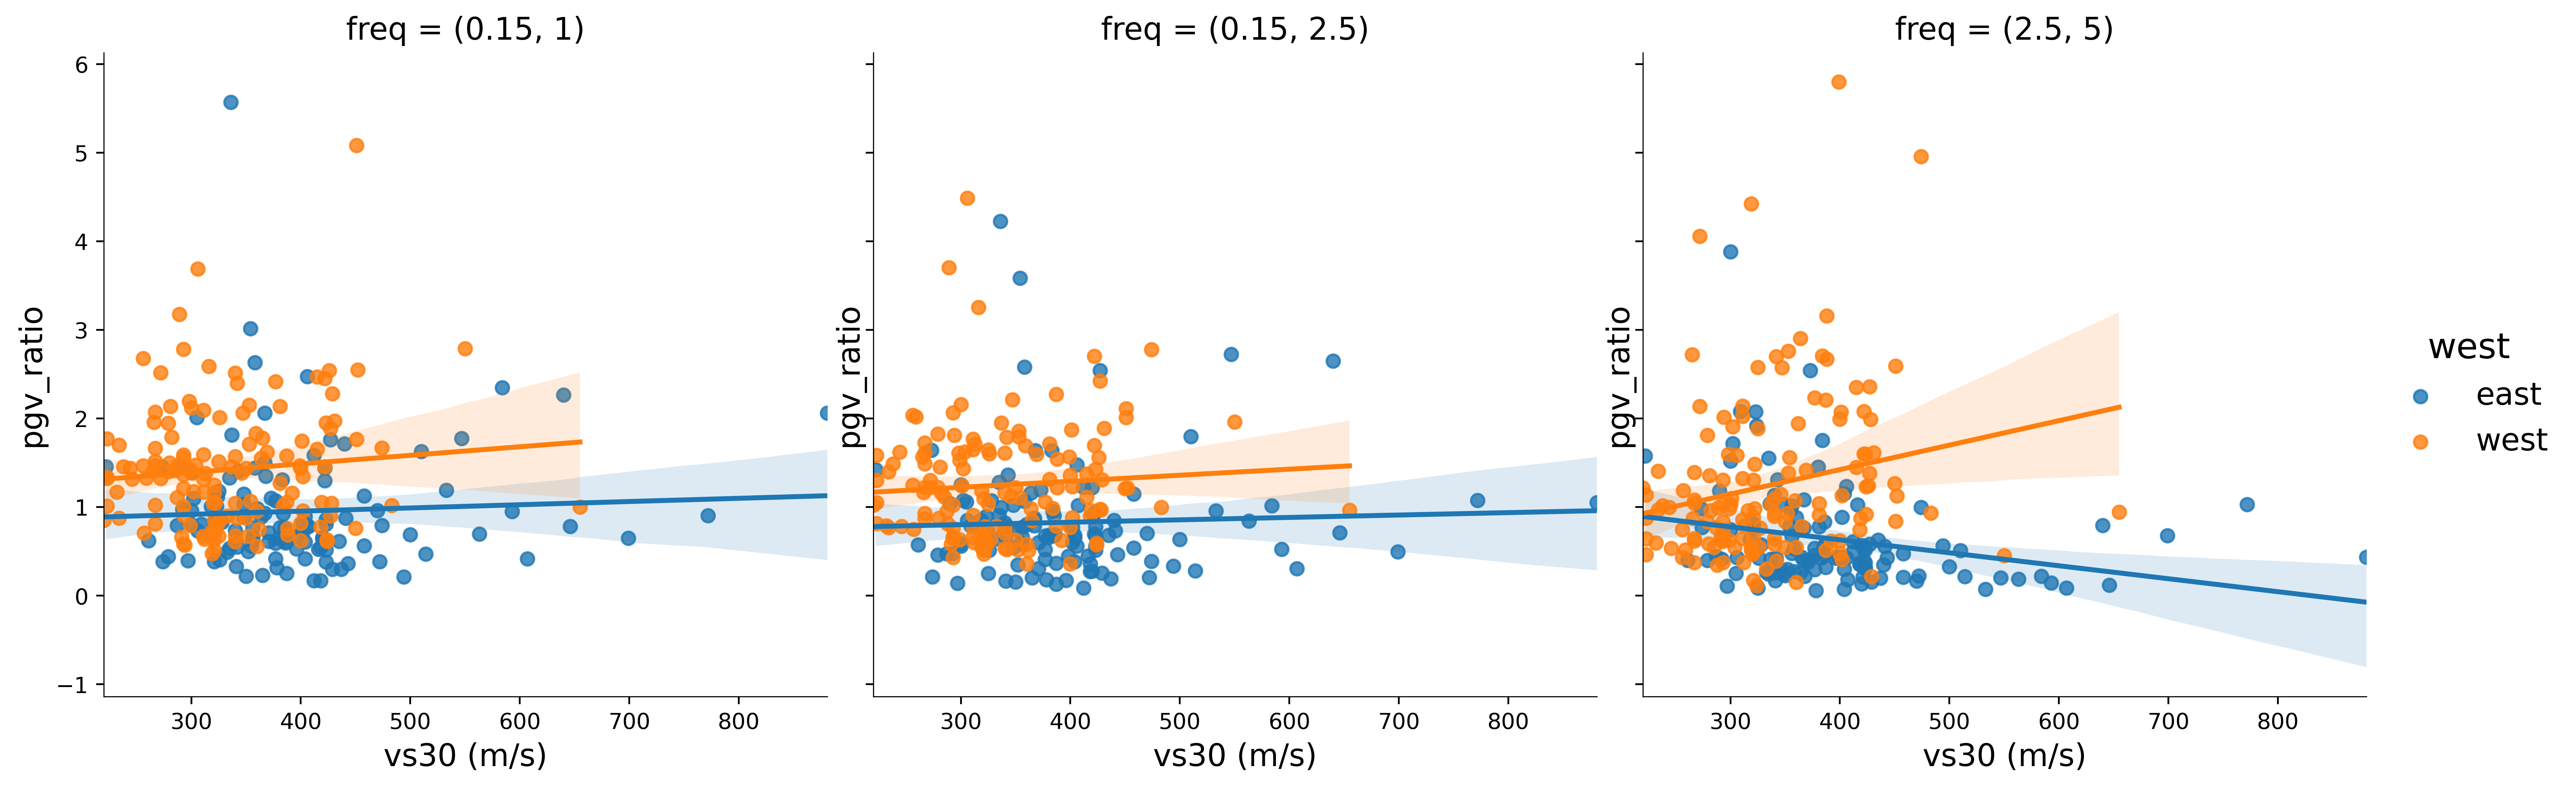

In [71]:
fig = plt.figure(dpi=300)
g = sns.lmplot(x='vs30', y='pgv', data=out[out['model']!='rec'], col='freq', hue='west')
g.set(xlabel='vs30 (m/s)', ylabel='pgv_ratio')

<Figure size 1800x1200 with 0 Axes>

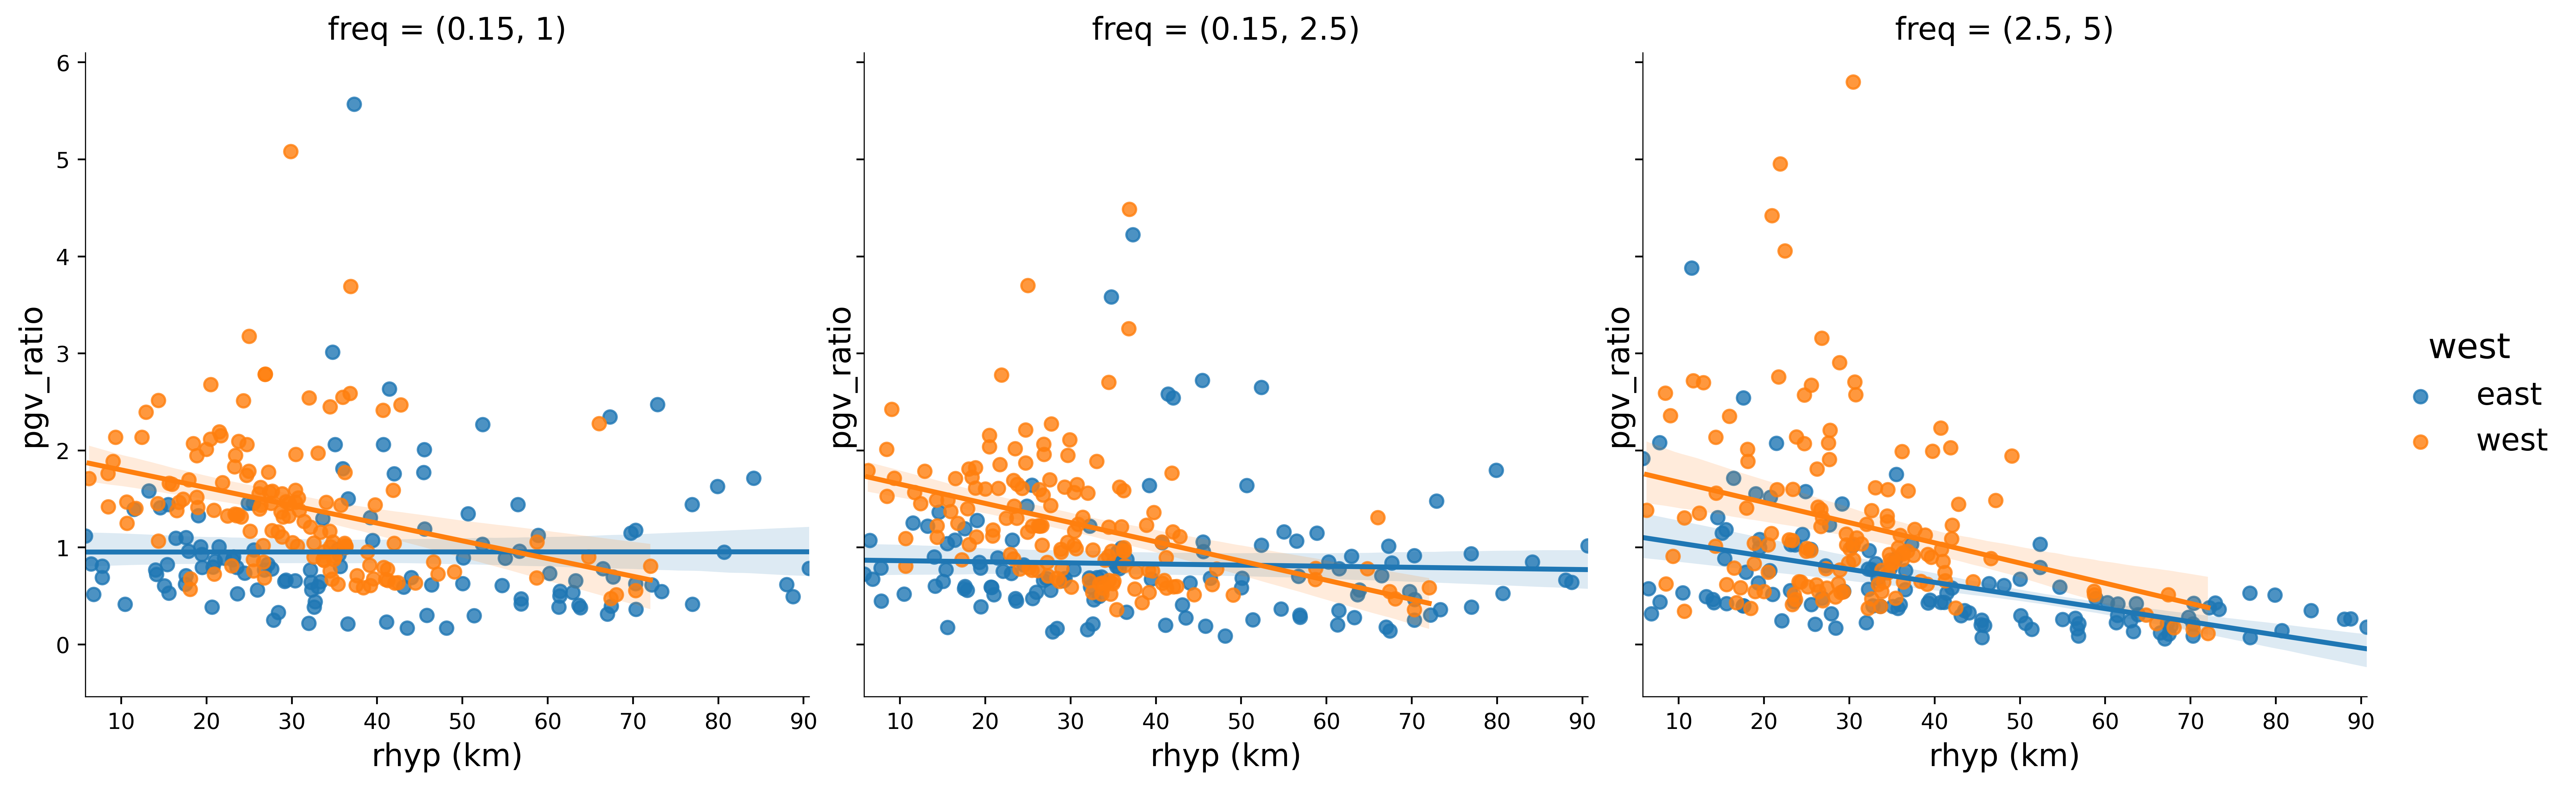

In [73]:
fig = plt.figure(dpi=300)
g = sns.lmplot(x='rhyp', y='pgv', data=out[out['model']!='rec'], col='freq', hue='west')
g.set(xlabel='rhyp (km)', ylabel='pgv_ratio')

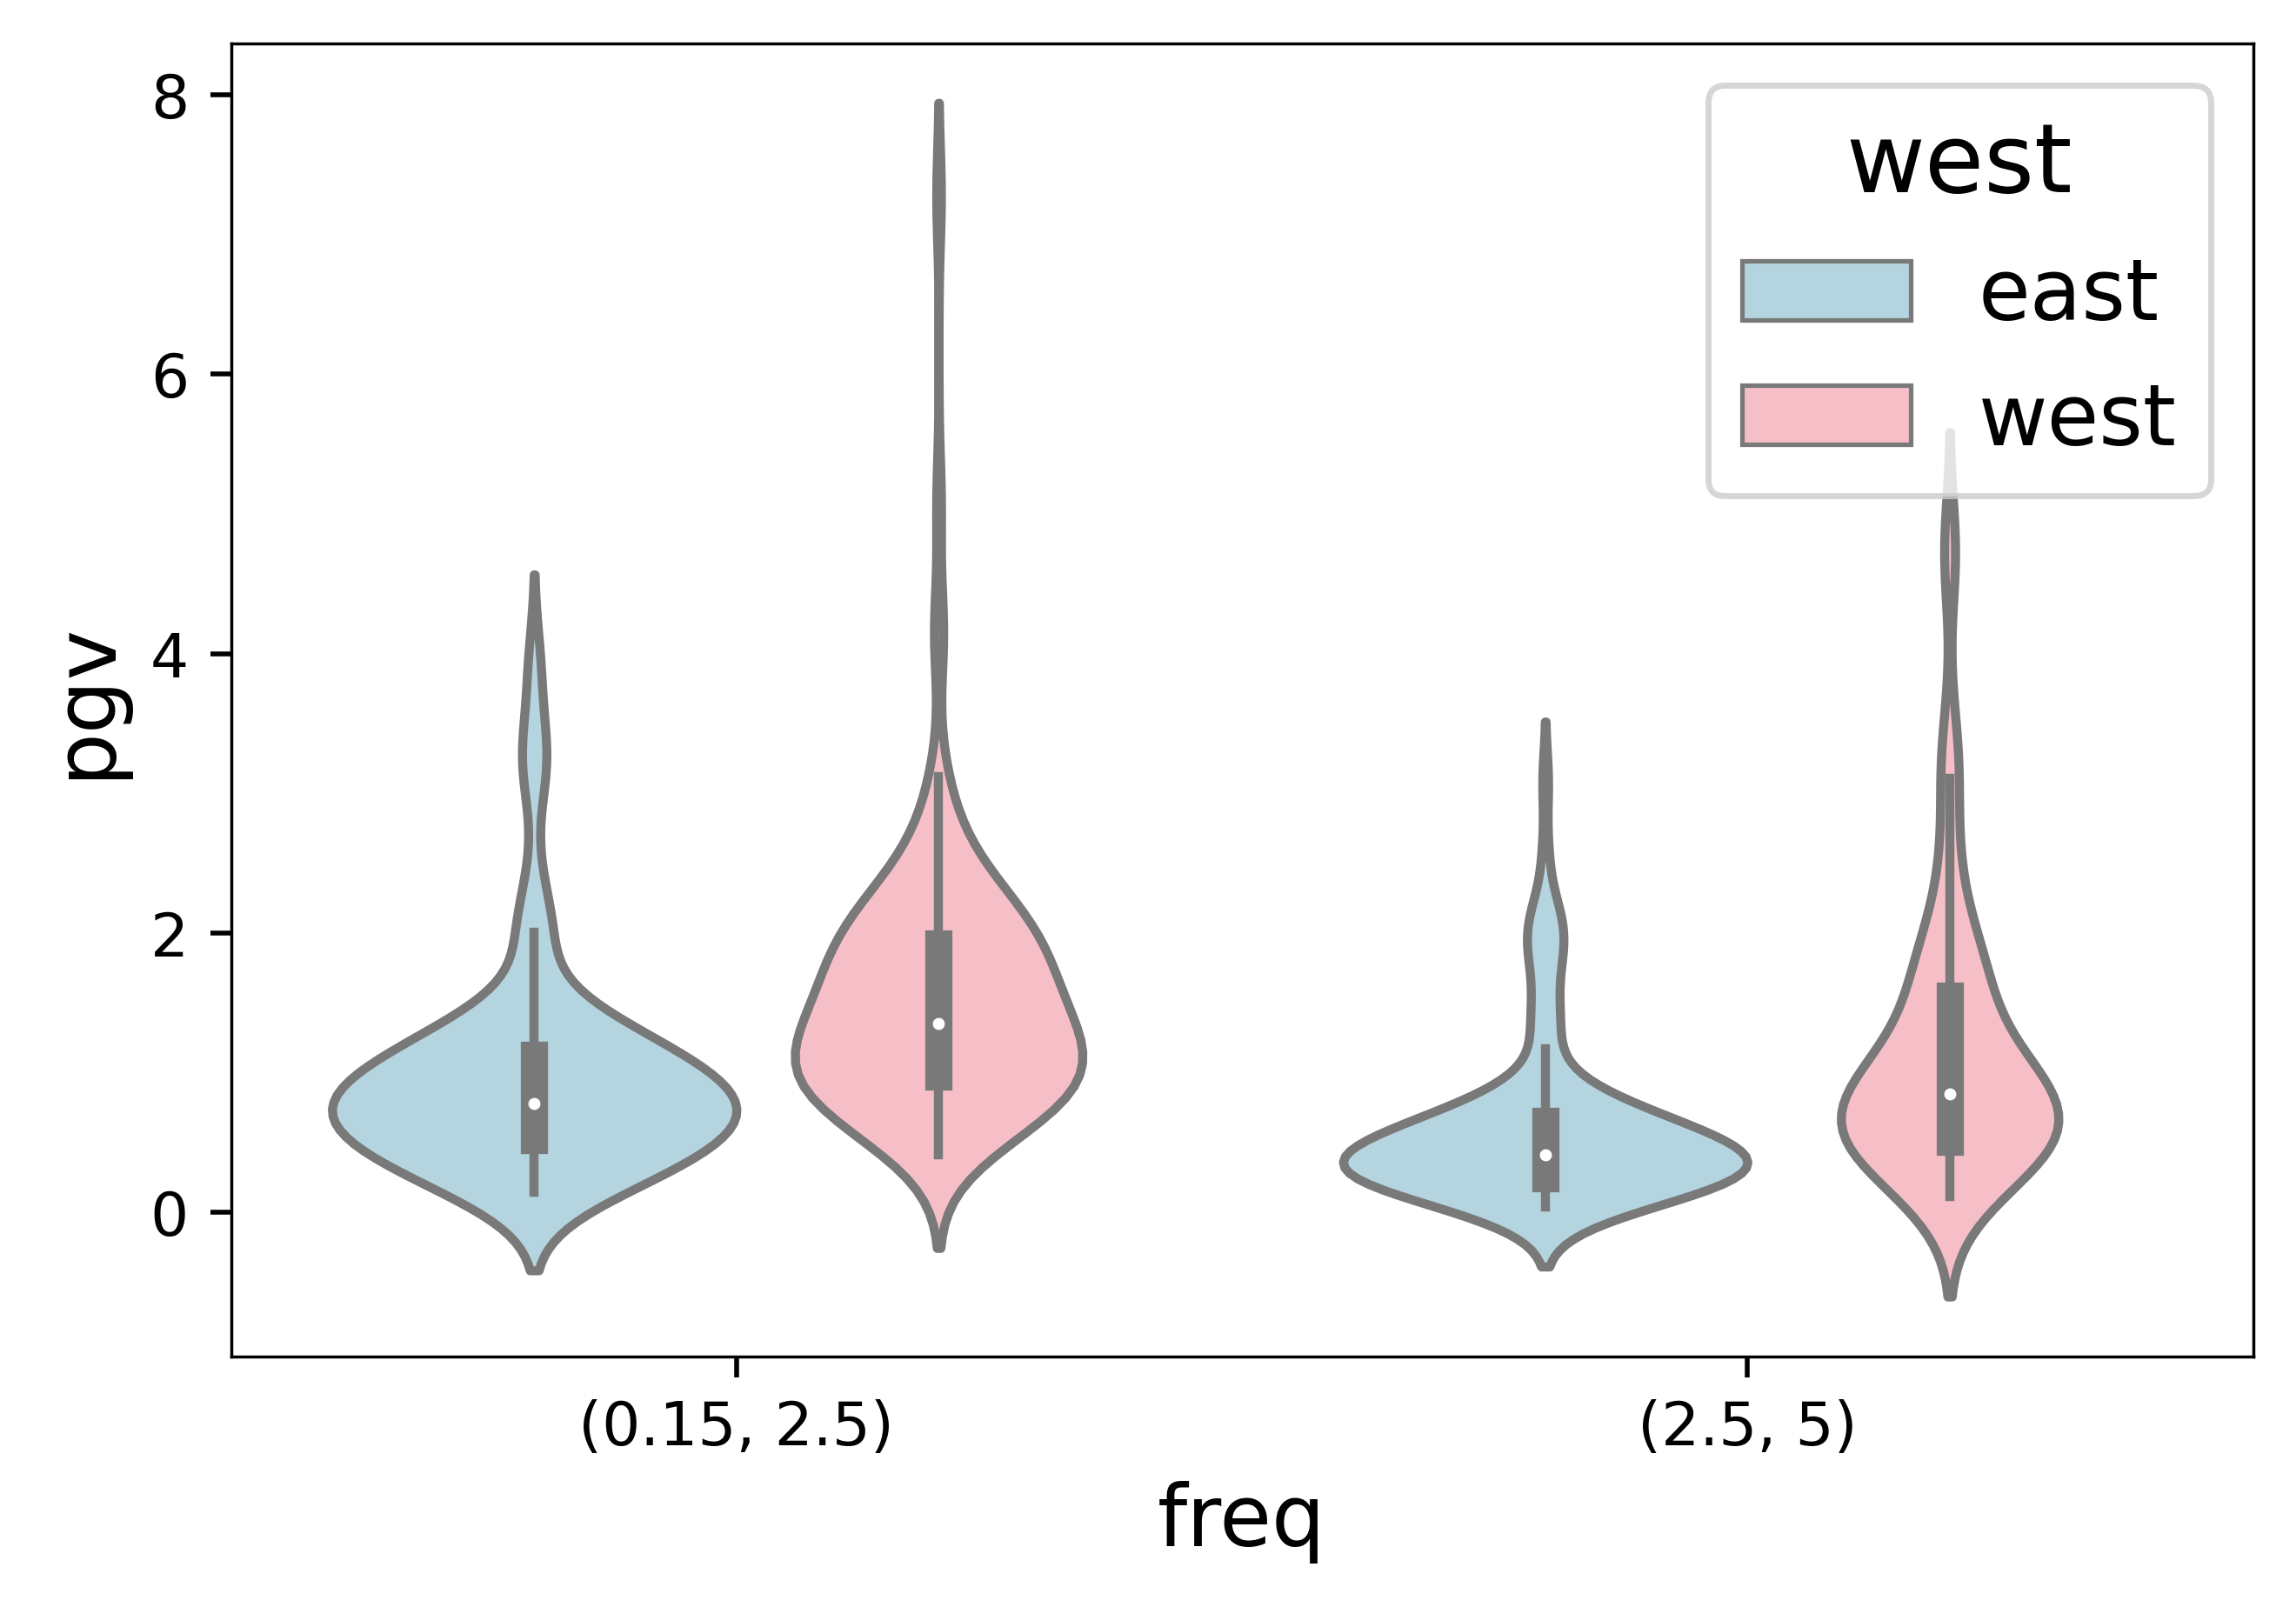

In [529]:
g = sns.violinplot(x="freq", y='pgv', data=out, hue='west',
                  palette=["lightblue", "lightpink"])
#g.set(xlabel='rhyp (km)', ylabel='pgv_ratio')

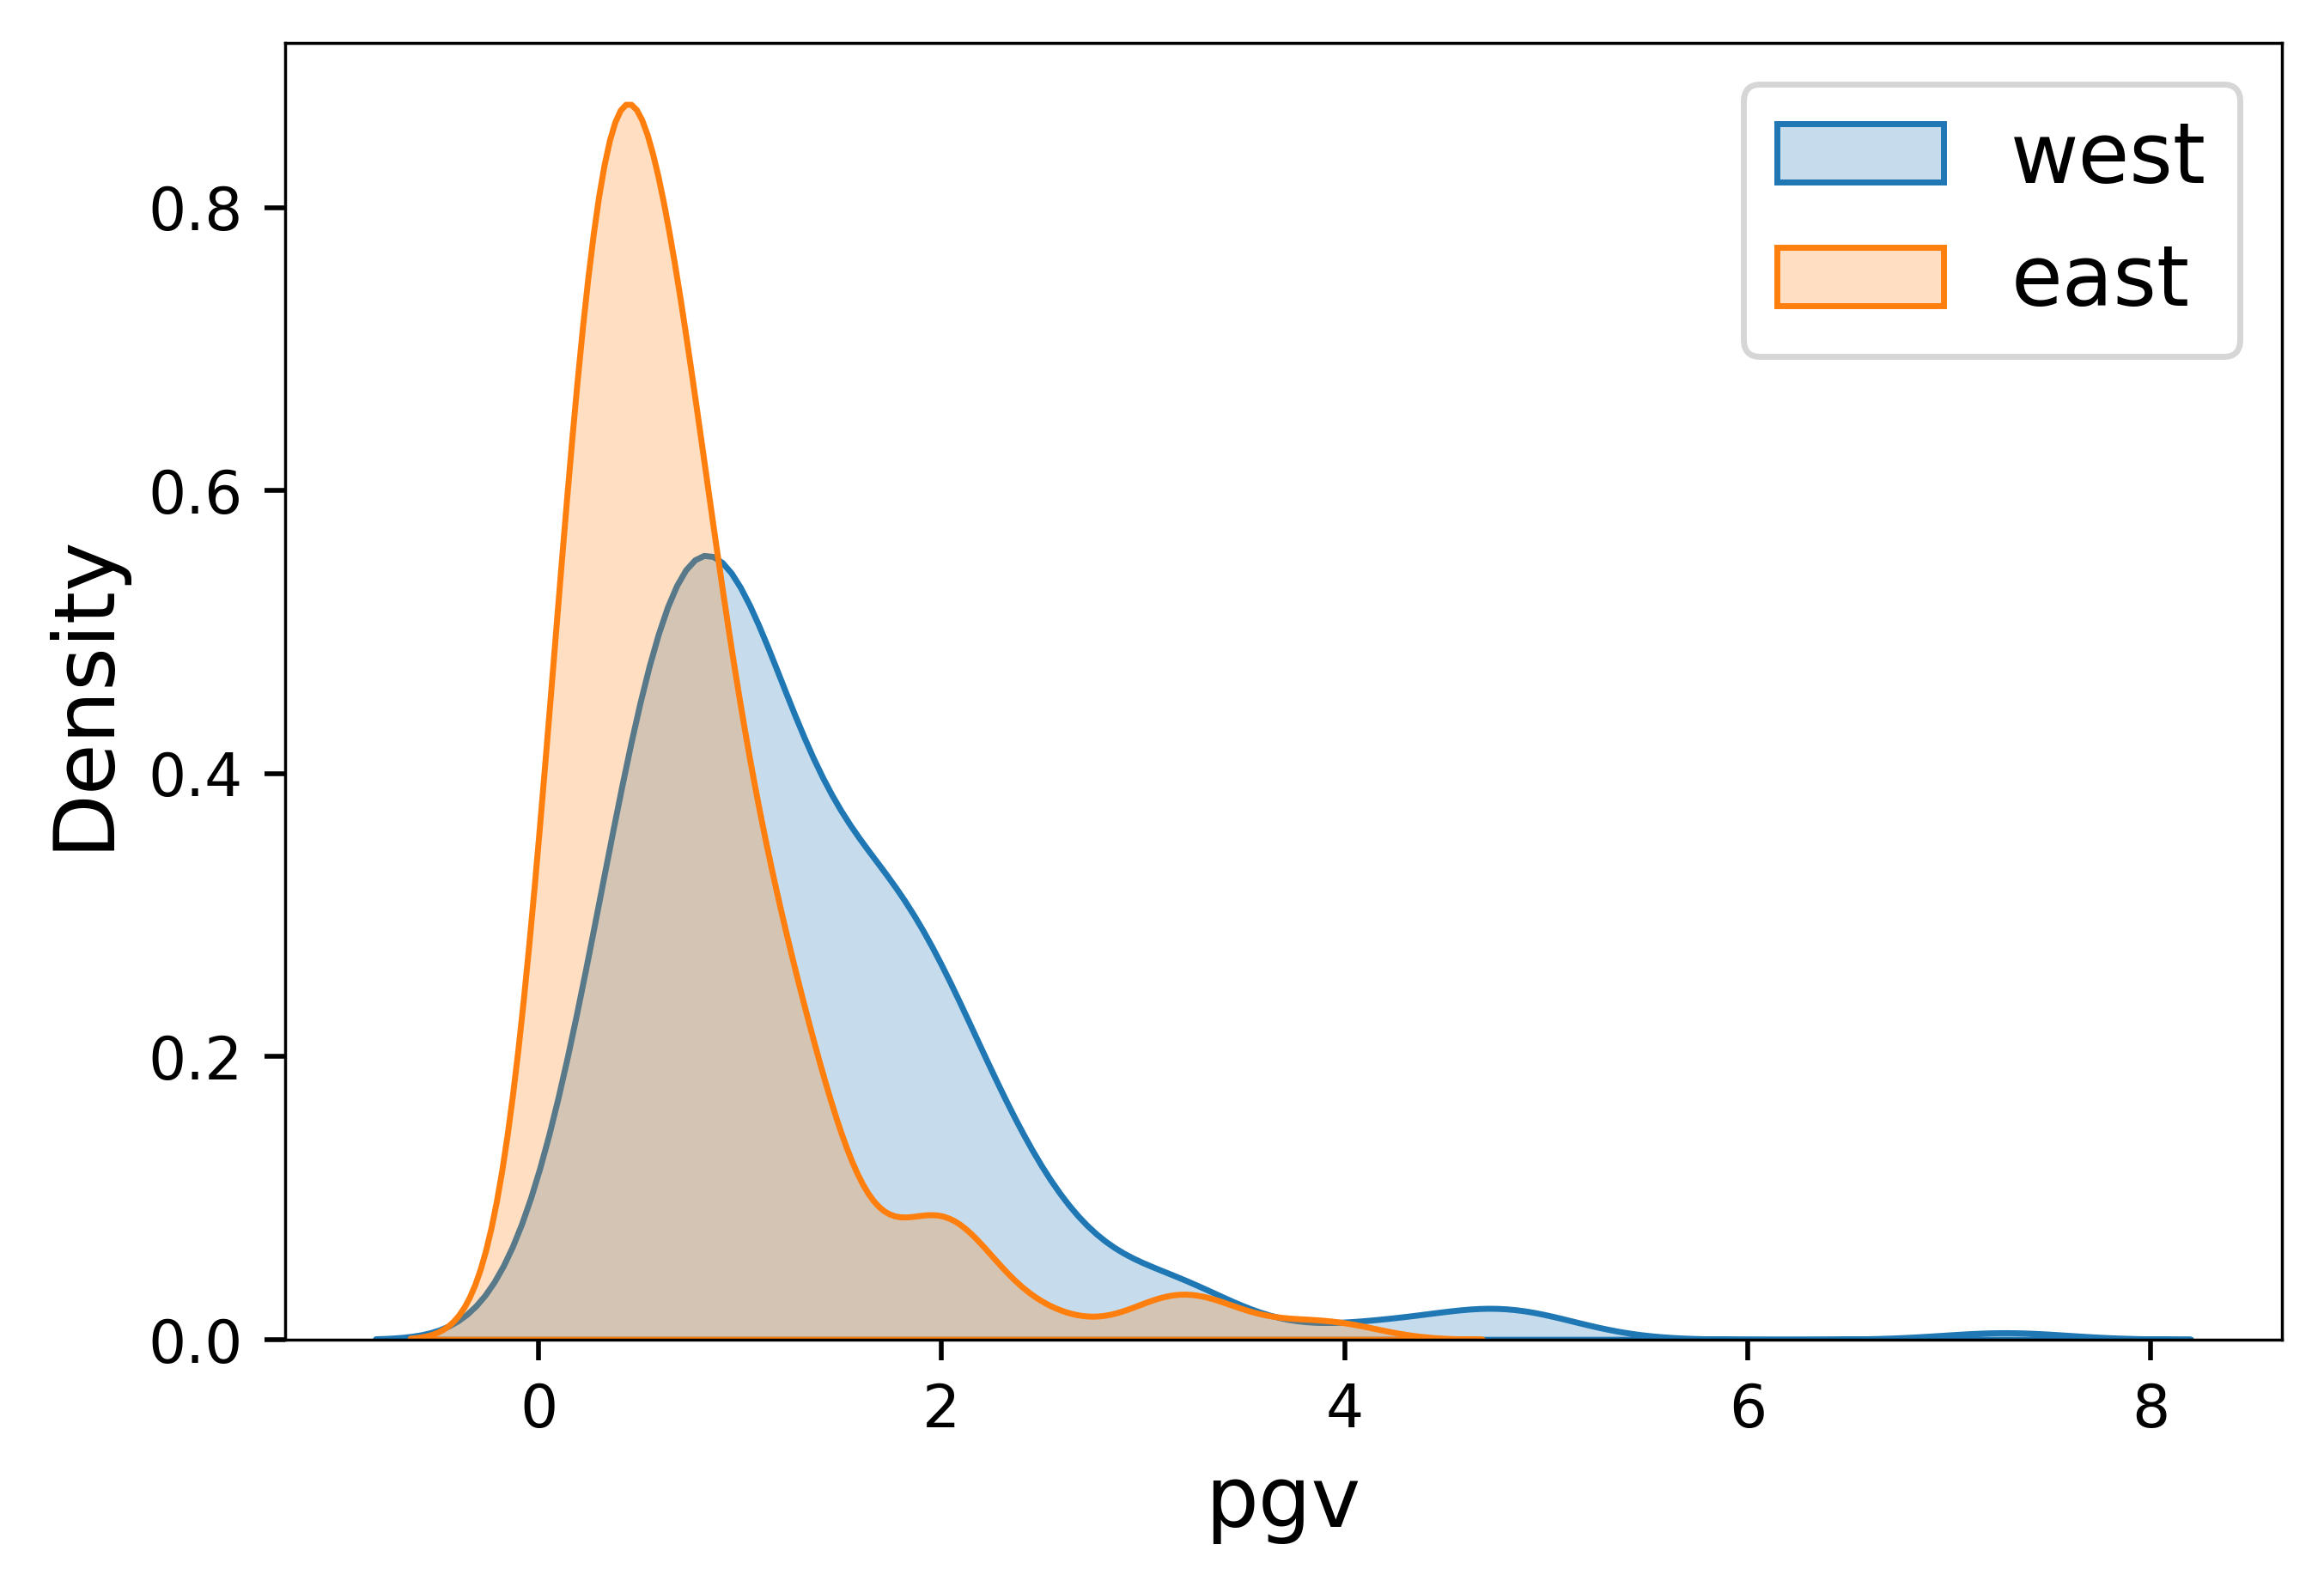

In [528]:
sns.kdeplot(out.pgv[out.west=='west'], label='west', shade=True)
sns.kdeplot(out.pgv[out.west=='east'], label='east', shade=True)
plt.legend()